<a href="https://colab.research.google.com/github/JadarTheObscurity/rl_tic_tac_toe/blob/main/RL_Tic_tac_toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [337]:
class Game:
    WIN_REWARD = 1
    TIE_REWARD = 0
    LOSE_REWARD = -1
    INVALID_MOVE_REWARD = -1

    def __init__(self):
        self.board = np.array([0] * 9).astype(np.float32)
        self.current_player = 1

    def is_end(self):
        # Define the winning combinations (indices) in tic-tac-toe
        winning_combinations = [(0, 1, 2), (3, 4, 5), (6, 7, 8),  # Rows
                                (0, 3, 6), (1, 4, 7), (2, 5, 8),  # Columns
                                (0, 4, 8), (2, 4, 6)]             # Diagonals

        # Check for a win for either player (1 or -1)
        for player in [1, -1]:
            for combo in winning_combinations:
                if all(self.board[i] == player for i in combo):
                    return player  # Player has won

        # Check for a tie (all positions filled)
        if 0 not in self.board:
            return 0  # It's a tie

        # If none of the above conditions are met, the game is still ongoing
        return None

    def play(self, pos):
        # Check if the position is valid (within the board and not already occupied)
        if 0 <= pos < len(self.board) and self.board[pos] == 0:
            # Make the move
            self.board[pos] = self.current_player

            # Check if the game has ended
            game_result = self.is_end()

            if game_result == 1:
                reward = (self.LOSE_REWARD, self.WIN_REWARD)  # Player 1 wins
            elif game_result == -1:
                reward = (self.WIN_REWARD, self.LOSE_REWARD)  # Player -1 wins
            elif game_result == 0:
                reward = (self.TIE_REWARD, self.TIE_REWARD)  # It's a tie
            else:
                reward = None  # Game continues

            # Switch to the other player's turn
            self.current_player *= -1

        else:
            # Invalid move
            if self.current_player == 1:
                reward = (self.WIN_REWARD, self.INVALID_MOVE_REWARD)  # Player -1 wins
            else:
                reward = (self.INVALID_MOVE_REWARD, self.WIN_REWARD)  # Player 1 wins
        return reward
    def get_random_valid_move(self):
        # Generate a random permutation of the board indices
        random_indices = np.random.permutation(9)

        # Check each index to see if it's a valid move
        for idx in random_indices:
            if self.board[idx] == 0:
                return idx
        return 0

    def get_random_move(self):
        # Generate a random permutation of the board indices
        random_indices = np.random.permutation(9)
        return random_indices[0]
    def get_random_invalid_move(self):
      # Generate a random permutation of the board indices
      random_indices = np.random.permutation(9)

      # Check each index to see if it's a valid move
      for idx in random_indices:
          if self.board[idx] != 0:
              return idx
      return 0



In [338]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [339]:
from torch.utils.data import Dataset

class TicTacToeDataset(Dataset):
  def __init__(self, data):
    self.data = data
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [366]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(9, 81)
    self.fc2 = nn.Linear(81, 81)
    self.fc3 = nn.Linear(81, 9)
    # self.seq = nn.Sequential(
    #     nn.Linear(9, 81),
    #     nn.ReLU(),
    #     nn.Linear(81, 273),
    #     nn.ReLU(),
    #     nn.Linear(273, 81),
    #     nn.LeakyReLU(),
    #     nn.Linear(81, 9),
    # )

  def forward(self, x):
    x = x.view(-1, 9)
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)
    # x = self.seq(x)
    return x

In [367]:
model = NN()

In [449]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
def compete(model, exp):
  model.eval()
  num_games = 100
  model_win = 0
  cum_game_step = 0
  model_player = -1
  model_pos_statistic = [0] * 9
  # Start the game loop
  for i in range(num_games):
    game = Game()
    game_step = 0
    while True:
        game_step += 1
        prev_board = game.board.copy()
        current_player = game.current_player
        if current_player == model_player:
          # model plays
          pos = int(torch.argmax(model(torch.from_numpy(game.board))).numpy())
          model_pos_statistic[pos] += 1
        else:
          # Get user input for the next move
          try:
              pos = game.get_random_valid_move()
          except ValueError:
              print("Invalid input. Please enter a number between 0 and 8.")
              continue
        # Play the move and get the reward
        reward = game.play(pos)
        curr_board = game.board.copy()
        reward_idx = 0 if current_player == -1 else 1
        model_reward_idx = 0 if model_player == -1 else 1
        player_reward_idx = 1 if model_player == -1 else 0
        if reward is None:
          exp.append((prev_board, pos, 0, curr_board))
        else:
          if reward[model_reward_idx] > reward[player_reward_idx]:
            model_win += 1
          exp.append((prev_board, pos, reward[reward_idx], curr_board))
          break
    cum_game_step += game_step
  print(f"Avg game step {cum_game_step / num_games} Model win rate {model_win / num_games}")
  print(f"Model pos statistic {model_pos_statistic}")

def train_model(model, num_epoch, exp , losses):
  print(f"Experience {len(exp)}")
  training_data = TicTacToeDataset(exp)
  train_dataloader = DataLoader(training_data, batch_size=1024, shuffle=True)
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

  model_old = NN()
  gamma = 0.8
  for epoch in range(num_epoch):
    model_old.load_state_dict(model.state_dict())
    for batch_idx, (st, at, rt, stt) in enumerate(train_dataloader):
      optimizer.zero_grad()
      pred = model(st)[torch.arange(len(at)), at.squeeze()]
      Qtt, Qtt_idx = torch.max(model_old(stt), dim=1)
      target = rt + gamma * Qtt
      loss = torch.square(target - pred).mean()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    scheduler.step()
  print(f"Mean loss {np.mean(np.array(losses[-num_epoch:]))}")


In [450]:
exp = [] # (st, at, rt, st+1)
losses = []

In [ ]:
num_cycle = 100
for cycle in range(num_cycle):
  print(f"Cycle: {cycle}")
  compete(model, exp)
  train_model(model, 100, exp, losses)

Cycle: 0
Avg game step 6.85 Model win rate 0.62
Model pos statistic [33, 14, 43, 27, 58, 73, 28, 11, 37]
Experience 685
Mean loss 0.012905894508585335
Cycle: 1
Avg game step 7.19 Model win rate 0.61
Model pos statistic [27, 24, 38, 30, 60, 72, 39, 13, 37]
Experience 1404
Mean loss 0.013046651715412735
Cycle: 2
Avg game step 7.07 Model win rate 0.66
Model pos statistic [28, 18, 29, 47, 60, 69, 33, 15, 38]
Experience 2111
Mean loss 0.01462204831186682
Cycle: 3
Avg game step 7.02 Model win rate 0.69
Model pos statistic [26, 11, 35, 39, 55, 70, 30, 16, 54]
Experience 2813
Mean loss 0.014368637008592486
Cycle: 4
Avg game step 6.99 Model win rate 0.61
Model pos statistic [24, 18, 26, 43, 62, 80, 33, 9, 35]
Experience 3512
Mean loss 0.01377937214449048
Cycle: 5
Avg game step 6.88 Model win rate 0.65
Model pos statistic [29, 13, 29, 40, 55, 71, 34, 16, 40]
Experience 4200
Mean loss 0.013800984900444745
Cycle: 6
Avg game step 6.96 Model win rate 0.65
Model pos statistic [38, 17, 37, 33, 44, 80,

In [421]:
# Create a new game instance
from google.colab import output
import random
model.eval()
num_games = 1000
model_win = 0
cum_game_step = 0
model_player = -1
# Start the game loop
for i in range(num_games):
  game = Game()
  game_step = 0
  while True:
      game_step += 1
      # Print the current board
      # print("Current Board:")
      prev_board = game.board.copy()
      current_player = game.current_player
      # for i in range(3):
          # print(game.board[i * 3:i * 3 + 3])
      if current_player == model_player:
        # model plays
        # pos = int(torch.argmax(model(torch.from_numpy(game.board))).numpy())
        # print(f"Model plays {pos}")
        if random.random() < 0.3:
          pos = game.get_random_invalid_move()
        else:
          pos = game.get_random_valid_move()

      else:
        # Get user input for the next move
        try:
            # pos = int(input(f"Player {game.current_player}, enter your move (0-8): "))
            pos = game.get_random_valid_move()
        except ValueError:
            print("Invalid input. Please enter a number between 0 and 8.")
            continue
      # Play the move and get the reward
      reward = game.play(pos)
      curr_board = game.board.copy()
      reward_idx = 0 if current_player == -1 else 1
      model_reward_idx = 0 if model_player == -1 else 1
      player_reward_idx = 1 if model_player == -1 else 0
      if reward is None:
        pass
        exp.append((prev_board, pos, 0, curr_board))
      else:
        if reward[model_reward_idx] > reward[player_reward_idx]:
          model_win += 1
        exp.append((prev_board, pos, reward[reward_idx], curr_board))
        # print(f"{reward}")
        break
  cum_game_step += game_step
print(f"Avg game step {cum_game_step / num_games} Model win rate {model_win / num_games}")

Avg game step 4.912 Model win rate 0.101


In [404]:
for e in exp[10:30]:
  print(e)

(array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 2, -1, array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32))
(array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 5, -1, array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))
(array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 5, -1, array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))
(array([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32), 8, -1, array([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))
(array([0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), 4, -1, array([0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))
(array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 2, -1, array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32))
(array([0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), 6, -1, array([0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))
(array([0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 5, -1, array([0., 0., 0., 0., 0., 1., 0., 0

In [422]:
from torch.utils.data import DataLoader
print(len(exp))
training_data = TicTacToeDataset(exp)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

4912


In [423]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr=0.01) # Change this from Adadelta to Adam drastically improves loss
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [424]:
model_old = NN()
model_old.load_state_dict(model.state_dict())

<All keys matched successfully>

In [425]:
from tqdm import tqdm
num_epoch = 1000
gamma = 0.1
model.train()
model_old.eval()
for epoch in tqdm(range(num_epoch)):
  model_old.load_state_dict(model.state_dict())
  for batch_idx, (st, at, rt, stt) in enumerate(train_dataloader):
    optimizer.zero_grad()
    pred = model(st)[torch.arange(len(at)), at.squeeze()]
    Qtt, Qtt_idx = torch.max(model_old(stt), dim=1)
    target = rt + gamma * Qtt
    loss = torch.square(target - pred).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  scheduler.step()
  # print(f"Mean loss {np.mean(np.array(losses[-num_epoch:]))}")

100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


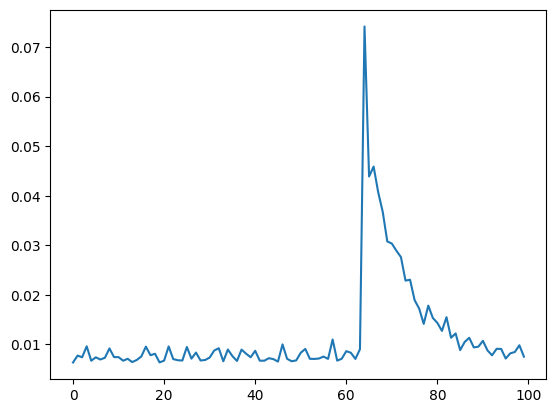

In [443]:
import matplotlib.pyplot as plt
plt.plot(losses[-100:])

In [427]:
input = torch.from_numpy(np.eye(9).astype(np.float32))
output = model(input)
output = output.detach().numpy()
np.set_printoptions(precision=3, suppress=True)
for i in range(9):
  print(output[i])

[-0.988  0.006 -0.043 -0.15  -0.058 -0.088 -0.132 -0.249 -0.088]
[ 0.021 -0.978 -0.154 -0.141 -0.141 -0.122 -0.218 -0.137 -0.169]
[-0.079 -0.088 -0.851 -0.175 -0.179 -0.066 -0.167 -0.156 -0.178]
[ 0.043 -0.047 -0.137 -0.939 -0.148 -0.136 -0.121 -0.127 -0.248]
[ 0.021  0.043 -0.143 -0.095 -1.011 -0.026 -0.139  0.    -0.05 ]
[-0.038 -0.016 -0.15  -0.196 -0.114 -0.981 -0.16  -0.095 -0.145]
[-0.104 -0.042 -0.053 -0.073 -0.159 -0.046 -0.961 -0.099 -0.189]
[-0.076  0.041 -0.075 -0.122 -0.015 -0.184 -0.086 -0.937 -0.058]
[-0.102 -0.122 -0.121 -0.074  0.009 -0.144 -0.176 -0.091 -1.001]


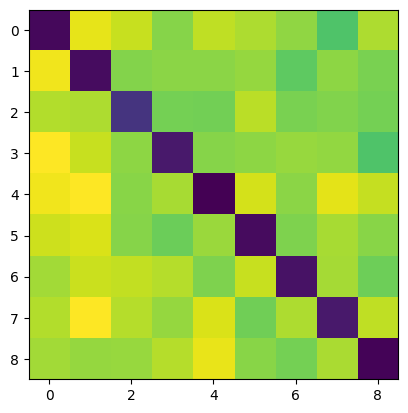

In [428]:
plt.imshow(output)

In [439]:
# Create a new game instance
from google.colab import output
import random
import builtins
model.eval()
num_games = 1
model_win = 0
cum_game_step = 0
model_player = -1
# Start the game loop
for i in range(num_games):
  game = Game()
  game_step = 0
  while True:
      game_step += 1
      # Print the current board
      print("Current Board:")
      prev_board = game.board.copy()
      current_player = game.current_player
      for i in range(3):
          print(game.board[i * 3:i * 3 + 3])
      if current_player == model_player:
        # model plays
        pos = int(torch.argmax(model(torch.from_numpy(game.board))).numpy())
        print(f"Model plays {pos}")

      else:
        # Get user input for the next move
        try:
            pos = builtins.input(f"Player {current_player}, enter your move (0-8): ")
            pos = int(pos)
            # pos = game.get_random_valid_move()
        except ValueError:
            print("Invalid input. Please enter a number between 0 and 8.")
            continue
      # Play the move and get the reward
      reward = game.play(pos)
      curr_board = game.board.copy()
      reward_idx = 0 if current_player == -1 else 1
      model_reward_idx = 0 if model_player == -1 else 1
      player_reward_idx = 1 if model_player == -1 else 0
      if reward is None:
        pass
        exp.append((prev_board, pos, 0, curr_board))
      else:
        if reward[model_reward_idx] > reward[player_reward_idx]:
          model_win += 1
        exp.append((prev_board, pos, reward[reward_idx], curr_board))
        print(f"{reward}")
        break
  cum_game_step += game_step
print(f"Avg game step {cum_game_step / num_games} Model win rate {model_win / num_games}")

Current Board:
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
Player 1, enter your move (0-8): 1
Current Board:
[0. 1. 0.]
[0. 0. 0.]
[0. 0. 0.]
Model plays 4
Current Board:
[0. 1. 0.]
[ 0. -1.  0.]
[0. 0. 0.]
Player 1, enter your move (0-8): 0
Current Board:
[1. 1. 0.]
[ 0. -1.  0.]
[0. 0. 0.]
Model plays 6
Current Board:
[1. 1. 0.]
[ 0. -1.  0.]
[-1.  0.  0.]
Player 1, enter your move (0-8): 2
(-1, 1)
Avg game step 5.0 Model win rate 0.0
